In [1]:
from __future__ import print_function, division
from keras.datasets import fashion_mnist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K
import scipy

C:\Users\kenneth\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
name = 'fashion_INFOGAN'
if not os.path.exists("saved_model/"+name):
        os.mkdir("saved_model/"+name)
if not os.path.exists("images/"+name):
        os.mkdir("images/"+name)

In [3]:
# Download the dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print('X_train', X_train.shape,'y_train', y_train.shape)
print('X_test', X_test.shape,'y_test', y_test.shape)

X_train (60000, 28, 28) y_train (60000,)
X_test (10000, 28, 28) y_test (10000,)


In [4]:
input_classes = pd.Series(y_train).nunique()
input_classes

10

In [5]:
# Training Labels are evenly distributed
Train_label_count = pd.Series(y_train).value_counts()
Train_label_count

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
dtype: int64

In [6]:
# Test Labels are evenly distributed
Test_label_count = pd.Series(y_test).value_counts()
Test_label_count

7    1000
6    1000
5    1000
4    1000
3    1000
2    1000
9    1000
1    1000
8    1000
0    1000
dtype: int64

In [7]:
#label dictionary from documentation
label_dict = {0: 'tshirt',
              1: 'trouser',
              2: 'pullover',
              3: 'dress',
              4: 'coat',
              5: 'sandal',
              6: 'shirt',
              7: 'sneaker',
              8: 'bag',
              9: 'boot'}

In [8]:
X_train[1].shape

(28, 28)

In [9]:
#input dimensions
input_rows = X_train[1][0]
input_cols = X_train[1][1]
input_channels = 1

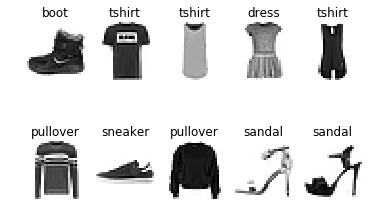

In [10]:
# plot images from the train dataset
for i in range(10):
    # define subplot
    a=plt.subplot(2, 5, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(X_train[i], cmap='gray_r')
    a.set_title(label_dict[y_train[i]])

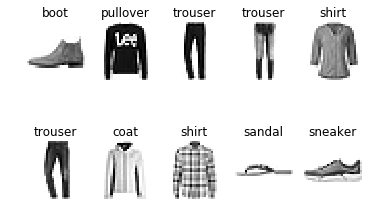

In [11]:
# plot images from the test dataset
for i in range(10):
    # define subplot
    a=plt.subplot(2, 5, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(X_test[i], cmap='gray_r')
    a.set_title(label_dict[y_test[i]])

In [12]:
class INFOGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.num_classes = 10
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 72


        optimizer = Adam(0.0002, 0.5)
        losses = ['binary_crossentropy', self.mutual_info_loss]

        # Build and the discriminator and recognition network
        self.discriminator, self.auxilliary = self.build_disk_and_q_net()

        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the recognition network Q
        self.auxilliary.compile(loss=[self.mutual_info_loss],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        gen_input = Input(shape=(self.latent_dim,))
        img = self.generator(gen_input)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        valid = self.discriminator(img)
        # The recognition network produces the label
        target_label = self.auxilliary(img)

        # The combined model  (stacked generator and discriminator)
        self.combined = Model(gen_input, [valid, target_label])
        self.combined.compile(loss=losses,
            optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=3, padding='same'))
        model.add(Activation("tanh"))

        gen_input = Input(shape=(self.latent_dim,))
        img = model(gen_input)

        model.summary()

        return Model(gen_input, img)


    def build_disk_and_q_net(self):

        img = Input(shape=self.img_shape)

        # Shared layers between discriminator and recognition network
        model = Sequential()
        model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Flatten())

        img_embedding = model(img)

        # Discriminator
        validity = Dense(1, activation='sigmoid')(img_embedding)

        # Recognition
        q_net = Dense(128, activation='relu')(img_embedding)
        label = Dense(self.num_classes, activation='softmax')(q_net)

        # Return discriminator and recognition network
        return Model(img, validity), Model(img, label)


    def mutual_info_loss(self, c, c_given_x):
        """The mutual information metric we aim to minimize"""
        eps = 1e-8
        conditional_entropy = K.mean(- K.sum(K.log(c_given_x + eps) * c, axis=1))
        entropy = K.mean(- K.sum(K.log(c + eps) * c, axis=1))

        return conditional_entropy + entropy

    def sample_generator_input(self, batch_size):
        # Generator inputs
        sampled_noise = np.random.normal(0, 1, (batch_size, 62))
        sampled_labels = np.random.randint(0, self.num_classes, batch_size).reshape(-1, 1)
        sampled_labels = to_categorical(sampled_labels, num_classes=self.num_classes)

        return sampled_noise, sampled_labels

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and categorical labels
            sampled_noise, sampled_labels = self.sample_generator_input(batch_size)
            gen_input = np.concatenate((sampled_noise, sampled_labels), axis=1)

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(gen_input)

            # Train on real and generated data
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)

            # Avg. loss
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator and Q-network
            # ---------------------

            g_loss = self.combined.train_on_batch(gen_input, [valid, sampled_labels])

            # Plot the progress
            #print ("%d [D loss: %.2f, acc.: %.2f%%] [Q loss: %.2f] [G loss: %.2f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[1], g_loss[2]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
                self.save_model()
                print ("%d [D loss: %.2f, acc.: %.2f%%] [Q loss: %.2f] [G loss: %.2f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[1], g_loss[2]))

    def sample_images(self, epoch):
        r, c = 10, 10

        fig, axs = plt.subplots(r, c)
        for i in range(c):
            sampled_noise, _ = self.sample_generator_input(c)
            label = to_categorical(np.full(fill_value=i, shape=(r,1)), num_classes=self.num_classes)
            gen_input = np.concatenate((sampled_noise, label), axis=1)
            gen_imgs = self.generator.predict(gen_input)
            gen_imgs = 0.5 * gen_imgs + 0.5
            for j in range(r):
                axs[j,i].imshow(gen_imgs[j,:,:,0], cmap='gray')
                axs[j,i].axis('off')
        fig.savefig("images/"+name+"/_%d.png" % epoch)
        plt.imread("images/"+name+"/_%d.png" % epoch)
        plt.show()
        plt.close()

    def save_model(self):

        def save(model, model_name):
            model_path = "saved_model/"+name+"/%s.json" % model_name
            weights_path = "saved_model/"+name+"/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "infogan_generator")
        save(self.discriminator, "infogan_discriminator")
        save(self.combined, "infogan_discriminator")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 6272)              457856    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 128)       512       
__________

C:\Users\kenneth\Anaconda3\lib\site-packages\keras\engine\training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


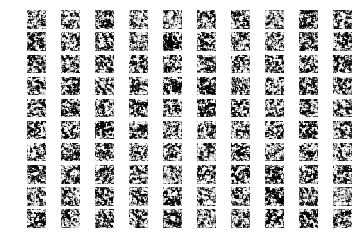

0 [D loss: 1.55, acc.: 24.22%] [Q loss: 0.81] [G loss: 2.95]


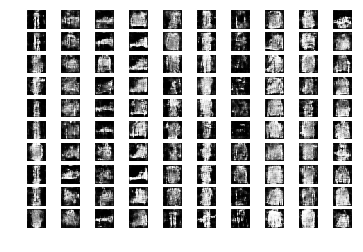

1000 [D loss: 0.70, acc.: 58.20%] [Q loss: 0.86] [G loss: 0.01]


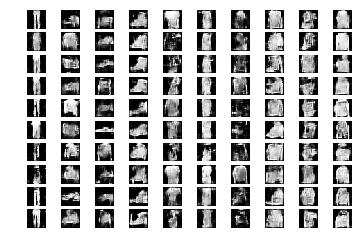

2000 [D loss: 0.73, acc.: 49.22%] [Q loss: 0.64] [G loss: 0.02]


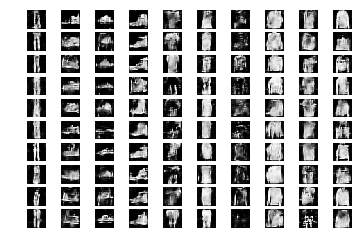

3000 [D loss: 0.71, acc.: 50.00%] [Q loss: 0.63] [G loss: 0.00]


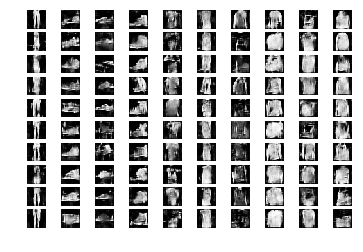

4000 [D loss: 0.68, acc.: 54.69%] [Q loss: 0.69] [G loss: 0.00]


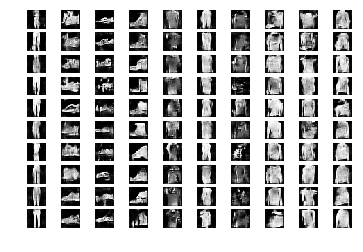

5000 [D loss: 0.68, acc.: 56.25%] [Q loss: 0.71] [G loss: 0.00]


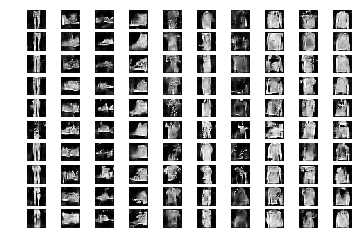

6000 [D loss: 0.69, acc.: 55.08%] [Q loss: 0.68] [G loss: 0.00]


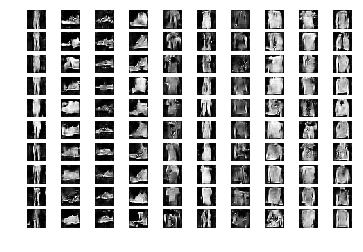

7000 [D loss: 0.70, acc.: 51.95%] [Q loss: 0.70] [G loss: 0.00]


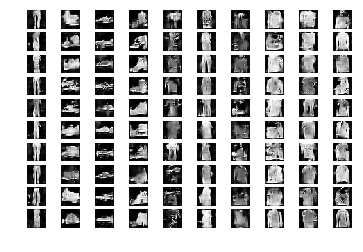

8000 [D loss: 0.70, acc.: 47.27%] [Q loss: 0.69] [G loss: 0.00]


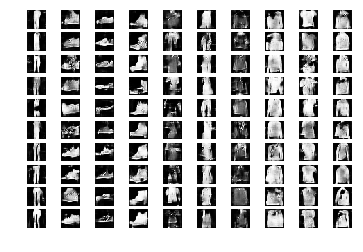

9000 [D loss: 0.70, acc.: 46.09%] [Q loss: 0.71] [G loss: 0.01]


In [13]:
infogan = INFOGAN()
infogan.train(epochs=10000, batch_size=128, sample_interval=1000)